In [3]:
"""
Check if the idea is worth to start generate experiment.

See complete code in Repo: kentarrito/AI-Scientist-Fork

To execute the code, use aws ec2 instance and run
Prerequisites:
```sh
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda.sh
bash ~/miniconda.sh -b -p $HOME/miniconda
~/miniconda/bin/conda init bash
source ~/.bashrc

sudo yum update
sudo yum install git

git clone -b recursive-function-in-generate_bs_agents_dataset https://github.com/kentarrito/AI-Scientist-Fork.git
conda create -n ai_scientist python=3.11
conda activate ai_scientist
sudo apt-get install texlive-full
cd AI-Scientist-Fork
pip install -r requirements.txt
```


```sh
export OPENAI_API_KEY="YOUR-APIKEY"
conda activate ai_scientist
python launch_agent_maker.py --model "gpt-4.1-nano-2025-04-14" --experiment 2d_diffusion --num-ideas 2
```

This will create ~/dataset folder and bs_agent_tree.json is created inside it
"""

!pip install ..

Processing /workspace/RMSearch
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 34.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of huggingface-hub to determine which version is compatible with other requirement

# Step 1 : Inference

## Generate Brainstorming Tree

In [ ]:
# GENERATE IDEAS
def generate_bs_agents_dataset(
        base_dir,
        agents,
        client,
        model,
        skip_generation=False,
        max_num_generations=20,
        num_reflections=5,
):
    if skip_generation:
        # Load existing ideas from file
        try:
            with open(osp.join(base_dir, "ideas.json"), "r") as f:
                ideas = json.load(f)
            print("Loaded existing ideas:")
            for idea in ideas:
                print(idea)
            return ideas
        except FileNotFoundError:
            print("No existing ideas found. Generating new ideas.")
        except json.JSONDecodeError:
            print("Error decoding existing ideas. Generating new ideas.")

    idea_str_archive = []
    with open(osp.join(base_dir, "seed_ideas.json"), "r") as f:
        seed_ideas = json.load(f)
    for seed_idea in seed_ideas:
        idea_str_archive.append(json.dumps(seed_idea))

    with open(osp.join(base_dir, "experiment.py"), "r") as f:
        code = f.read()

    with open(osp.join(base_dir, "prompt.json"), "r") as f:
        prompt = json.load(f)

    idea_system_prompt = prompt["system"]

    
    
    bs_msg_histories = {}  # {(depth,branch):[{"system":}...], ...}
    bs_agent_id_histories = {}  # {(depth,branch):id, ...}
    all_ideas = {}

    num_depth = 2
    num_branch = 2
    n_agents = len(agents)
    bs_agent_tree = {}  # [{"agent_id":, "node_id":[0], "bs_msg":[{"role":"system", "content":"..."}], "ideas":[{}], "children":[{"msg":[{"role":"user"}, {"role":"assistant"}]}]}, ]

    def build_bs_agent_tree(agents, *, num_depth=3, num_branch=2, seed=None):
        if seed is not None:
            random.seed(seed)
        if not agents:
            raise ValueError("agents list is empty.")

        n_agents = len(agents)

        def _grow(node, depth, forbidden):
            if depth == num_depth:
                return
            available = list(set(range(n_agents)) - forbidden)
            if not available:
                raise RuntimeError("Not enough distinct agents for the depth requested.")

            picked_a_idxs = random.sample(available, num_branch)
            for b in range(num_branch):
                a_idx = picked_a_idxs[b]
                child = {
                    "agent"   : agents[a_idx],
                    "agent_ids": node["agent_ids"] + [a_idx],
                    "agent_id": a_idx,
                    "node_ids" : node["node_ids"] + [b],
                    "bs_msg"  : [],
                    "ideas"   : [],
                    "children": [],
                }
                node["children"].append(child)

                _grow(child, depth + 1, forbidden | {a_idx})

        root = {"agent_id": None, "agent_ids": [], "node_ids": [], "bs_msg": [], "ideas": [], "children": []}
        _grow(root, 0, set())
        return root

    def get_assistant_msg(
        node,
        *,                          # keyword-only
        history_so_far,             # ancestor conversation
        prompt, code,
        client, model,
    ):
        """
        Returns a *new* history list that is `history_so_far`
        plus ONE user/assistant pair for this depth,
        and the parsed idea dict produced in that exchange.
        """
        if node["agent_ids"]==[]: agent_id = None
        else: agent_id = node["agent_ids"][-1]

        # ------------------------------------------------------------------ copy
        bs_msg = list(history_so_far)               # preserves ancestor msgs

        # --------------------------------------------------- construct user turn

        bs_sys_msg = brainstorming_system_msg.format(
            task_description = prompt["task_description"],
            code             = code,
        )

        bs_prompt = brainstorming_prompt.format(
            agent = agents[agent_id],
        )

        bs_txt, bs_msg = get_response_from_llm(
            bs_prompt,
            client         = client,
            model          = model,
            system_message = bs_sys_msg,
            msg_history    = bs_msg,
        )

        idea_prompt = idea_first_prompt.format(
            task_description = prompt["task_description"],
            code             = code,
            num_reflections  = num_reflections,
        )

        # talk to LLM *once* (temp_history is a throw-away list)
        idea_txt, msg_history = get_response_from_llm(
            idea_prompt,
            client         = client,
            model          = model,
            system_message = "",
            msg_history    = bs_msg,
        )

        # Iteratively improve task.
        if num_reflections > 1:
            msg_history = msg_history[-2:]
            for j in range(num_reflections - 1):
                idea_txt, msg_history = get_response_from_llm(
                    idea_reflection_prompt.format(
                        current_round=j + 2, num_reflections=num_reflections
                    ),
                    client=client,
                    model=model,
                    system_message=idea_system_prompt,
                    msg_history=msg_history,
                )
                ## PARSE OUTPUT
                json_output = extract_json_between_markers(idea_txt)
                assert (
                        json_output is not None
                ), "Failed to extract JSON from LLM output"
                #print()
                #print(f"Iteration {j + 2}/{num_reflections} Generated Ideas: ")
                #print(json_output)

                if "I am done" in idea_txt:
                    #print()
                    #print(f"Idea generation converged after {j + 2} iterations.")
                    break


        # parse idea
        idea_json = extract_json_between_markers(idea_txt) or {"idea": idea_txt,
                                                                    "agent": agents[agent_id]}
        return bs_msg, [idea_json]

    total_num_node = num_branch**(num_depth+1) - 2

    global populate_count
    populate_count = 0
    def populate_tree(node, history_so_far, **llm_kwargs):
        global populate_count
        """
        Depth-first traversal.
        history_so_far already obeys the 1 + depth*2 rule.
        """
        if node["agent_id"] is not None:         # skip dummy root
            node["bs_msg"], node["ideas"] = get_assistant_msg(
                node,
                history_so_far = history_so_far,
                **llm_kwargs,
            )
            next_history = node["bs_msg"]
            populate_count += 1
            print(f"populate count: {populate_count}/{total_num_node}")
        else:
            next_history = history_so_far

        for child in node["children"]:
            populate_tree(child, next_history, **llm_kwargs)

    print()
    print("Making Brainstorming Tree...")
    print(f"num_depth:{num_depth}, num_branch:{num_branch}, n_agents:{n_agents}, ")

    bs_agent_tree = build_bs_agent_tree(
        agents, num_depth=num_depth, num_branch=num_branch, seed=42
    )

    print(bs_agent_tree)

    print()
    print("Brainstorming and Genrating Ideas...")

    populate_tree(
        bs_agent_tree,
        history_so_far = [],      # start empty
        prompt         = prompt,
        code           = code,
        client         = client,
        model          = model,
    )

    ## SAVE IDEAS

    with open(osp.join(base_dir, "bs_agent_tree.json"), "w") as f:
        json.dump(bs_agent_tree, f, indent=4)

    return bs_agent_tree


## Check Each Node's Novelty

In [ ]:
def check_idea_novelty_in_bs_agent_tree(
    bs_agent_tree,  # {"agent_ids":[],"bs_msg":[],"children":[{same structure}, ]}
    base_dir,
    dataset_dir,
    client,
    model,
    max_num_iterations=10,
    engine="semanticscholar",
):
    with open(osp.join(base_dir, "experiment.py"), "r") as f:
        code = f.read()
    with open(osp.join(base_dir, "prompt.json"), "r") as f:
        prompt = json.load(f)
        task_description = prompt["task_description"]

    def check(ideas):
        idea = ideas[0]

        print(f"\nChecking novelty of idea: {idea['Name']}")
        
        novel = False
        msg_history = []
        papers_str = ""
        thought_output = ""

        for j in range(max_num_iterations):
            try:
                text, msg_history = get_response_from_llm(
                    novelty_prompt.format(
                        current_round=j + 1,
                        num_rounds=max_num_iterations,
                        idea=idea,
                        last_query_results=papers_str,
                    ),
                    client=client,
                    model=model,
                    system_message=novelty_system_msg.format(
                        num_rounds=max_num_iterations,
                        task_description=task_description,
                        code=code,
                    ),
                    msg_history=msg_history,
                )
                thought_output = extract_text_inside_backticks(text, "thought") or thought_output

                if "decision made: novel" in text.lower():
                    print("Decision made: novel after round", j)
                    novel = True
                    break
                if "decision made: not novel" in text.lower():
                    print("Decision made: not novel after round", j)
                    break

                # parse JSON
                json_output = extract_json_between_markers(text)
                assert json_output is not None, "Failed to extract JSON from LLM output"

                # search
                query = json_output.get("Query", "")
                papers = search_for_papers(query, result_limit=5, engine=engine)
                if not papers:
                    papers_str = "No papers found."
                else:
                    paper_strings = []
                    for i, paper in enumerate(papers):
                        paper_strings.append(
                                """{i}: {title}. {authors}. {venue}, {year}.\nNumber of citations: {cites}\nAbstract: {abstract}""".format(
                                    i=i,
                                    title=paper["title"],
                                    authors=paper["authors"],
                                    venue=paper["venue"],
                                    year=paper["year"],
                                    cites=paper["citationCount"],
                                    abstract=paper["abstract"],
                                )
                        )
                    papers_str = "\n\n".join(paper_strings)

            except Exception as e:
                print(f"Error: {e}")
                continue

        print()
        print(f"novelty: {novel}")

        return [novel]


    def add_novelty_to_tree(node, depth):

        if not node["ideas"] == []:
            if node["novelties"] == []:
                novelties = check(node["ideas"])
                node["novelties"] = novelties
                with open(osp.join(dataset_dir, f"bs_agent_tree.json"), "w") as f:
                    json.dump(bs_agent_tree, f, indent=4)

        for child in node["children"]:
            add_novelty_to_tree(child, depth + 1)
            

    #bs_agent_tree = {"agent_id": None, "agent_ids": [], "node_ids": [], "bs_msg": [], "ideas": [], "children": []}
    add_novelty_to_tree(bs_agent_tree, 0)

    return bs_agent_tree

# Step 2 : Make dataset_list

In [1]:
exp_dir = "/workspace/exp14"
# bs_agent_tree = {"agent_id": None, "agent_ids": [], "node_ids": [], "task": "", "bs_msg": [], "ideas": [], "novelty": True or False, "children": [{}, ...]}
bs_agent_tree_save_dir = "/workspace/AI-Scientist-Fork-dataset"
dataset_list_save_path = f"{exp_dir}/dataset_list.json"

import os
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

In [2]:

import json
import pandas as pd

def list_files(root_dir):
    file_paths = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for fname in filenames:
            file_paths.append(os.path.join(dirpath, fname))
    return file_paths


if not os.path.exists(dataset_list_save_path):

    bs_agent_trees = []
    all_files = list_files(bs_agent_tree_save_dir)

    for file_path in all_files:
        with open(file_path) as f:
            bs_agent_tree = json.load(f)

        bs_agent_trees.append(bs_agent_tree)
        

    def get_dataset_dict(task, idea, novelty):
        if "Novelty" in idea:
            del idea["Novelty"]
        if "Interestingness" in idea:
            del idea["Interestingness"]
        if "Feasibility" in idea:
            del idea["Feasibility"]

        
        idea = str(idea)
        print()
        print(len(task))
        print(len(idea))
        idea = idea[:4000]
        
        if novelty:
            return {
                "query":[{'role': 'user', 'content':f"Judge if the idea towards the task is novel;\n\nTask:{task}\n\nIdea:{idea}"}],
                "chosen_key":[{'role': 'assistant', 'content': 'Yes, the idea is novel.' }],
                "rejected_key":[{'role': 'assistant', 'content': 'No, the idea is not novel. Ask for tips from experts to get more novel idea.'}],
            }
        else:
            return {
                "query":[{'role': 'user', 'content':f"Judge if the idea towards the task is novel;\n\nTask:{task}\n\nIdea:{idea}"}],
                "chosen_key":[{'role': 'assistant', 'content':  'No, the idea is not novel. Ask for tips from experts to get more novel idea.'}],
                "rejected_key":[{'role': 'assistant', 'content': 'Yes, the idea is novel.'}],
            }


    dataset_list = []
    def walk(node, depth):
        global dataset_list

        if node["children"] == []:
            return 0

        else:
            for i, node_dict in enumerate(node["children"]):
                #dataset_dict = get_dataset_dict(node_dict)
                idea = node_dict["ideas"][0]
                task = node_dict["task"]
                novelties = node_dict["novelties"]

                try:
                    novelty = novelties[0]
                    walk(node_dict, depth + 1)
                    dataset_dict = get_dataset_dict(task, idea=idea, novelty=novelty)
                    dataset_list.append(dataset_dict)

                except Exception as e:
                    print(e)
                    continue

    for bs_agent_tree in bs_agent_trees:
        walk(bs_agent_tree, 0)

    with open(dataset_list_save_path, "w") as f:
        json.dump(dataset_list, f)
        
else:
    with open(dataset_list_save_path) as f:
        dataset_list = json.load(f)


82
684

82
723

82
669

82
641

82
681

82
663

82
604

82
645

82
800

82
1026

82
628

82
688

82
704

82
680

143
928

143
775

143
745

143
749

143
890

143
994

143
816

143
890

143
1012

143
794

143
759

143
739

143
937

143
895
list index out of range
list index out of range

1286
947
list index out of range

1286
795
list index out of range

505
822

505
696

505
738

505
711

505
746

505
789

505
765

505
611

505
781

505
612

505
643

505
794

505
748

505
712

352
806

352
710

352
711

352
731

352
624

352
802

352
729

352
900

352
886

352
912

352
775

352
748

352
872

352
704

358
814

358
771

358
791

358
783

358
883

358
1152

358
638

358
688

358
733

358
731

358
830

358
786

358
765

358
740

1222
815

1222
654

1222
686

1222
740

1222
700

1222
630

1222
946

1222
696

1222
776

1222
724

1222
754

1222
891

1222
899

1222
906

295
756

295
633

295
843

295
852

295
671

295
740

295
689

295
869

295
866

295
784

295
744

295
842

295
685

295
693

# Step 3 : Train Reward Model

In [1]:
from rmsearch import RMTrainer

model_name = "/workspace/llama3b-rm"
num_gpus = 1

rmtrainer = RMTrainer(model_name = model_name, num_gpus = num_gpus)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
exp_dir = "/workspace/exp14"
dataset_list_save_path = f"{exp_dir}/dataset_list.json"
#dataset_save_path = f"{exp_dir}/dataset"
#train_ids_save_path = f"{exp_dir}/train_ids.json"
#test_ids_save_path = f"{exp_dir}/test_ids.json"
test_size = 6

import json
with open(dataset_list_save_path) as f:
    dataset_list = json.load(f)

formatted_dataset = rmtrainer.prepare_dataset(dataset_list, base_dir = exp_dir, test_size = test_size)

Existed: /workspace/exp14/dataset


In [ ]:
from trl import RewardConfig
from peft import LoraConfig, TaskType

batch_size_per_device = 1
eval_batch_size_per_device = 1
model_save_dir = f"{exp_dir}/model2"


training_args = RewardConfig(
    output_dir=model_save_dir,
    per_device_train_batch_size=batch_size_per_device,
    per_device_eval_batch_size=eval_batch_size_per_device,
    eval_strategy="steps",
    eval_steps=10,
    eval_on_start=True,
    save_steps=10,
    logging_steps=1,
    num_train_epochs = 50,
    report_to=None,
    remove_unused_columns=False,
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    target_modules=["k_proj","q_proj","o_proj", "v_proj","down_proj","gate_proj","up_proj",],
    layers_to_transform=[25,26,27],
    r=16,
    lora_alpha=16,
    lora_dropout=0.1,
)

rmtrainer.train(formatted_dataset, training_args = training_args, peft_config = peft_config)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.0002, 0.9998] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

Step,Training Loss,Validation Loss,Accuracy
0,No log,6.246863,0.166667
10,5.128800,5.371452,0.166667
20,5.386800,3.832274,0.166667
30,2.032600,1.662233,0.166667
40,0.250000,0.436994,0.833333
50,5.461100,0.946060,0.833333
60,6.947300,1.323730,0.833333
70,0.000300,1.309200,0.833333
80,0.000800,1.336575,0.833333
90,0.001200,1.224653,0.833333


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.0006, 0.9994] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                  ┃ logits         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<|e… │ [0.005, 0.995] │
│                                               │                                                │                │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023          │                │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                        │                │
│                                               │                                                │                │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_header… │                │
│                                               │                                                │                │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel;   │                │
│                                               │                                                │                │
│ Task:You are given the following file to work │ Task:You are given the following file to work  │                │
│ with, that trains a low-dimensional diffusion │ with, that trains a low-dimensional diffusion  │                │
│ model on 4 different 2D datasets. The         │ model on 4 different 2D datasets. The          │                │
│ diffusion model is based on DDPM.             │ diffusion model is based on DDPM. Particularly │                │
│ Particularly interesting ideas would involve  │ interesting ideas would involve controllable   │                │
│ controllable generation, e.g. biased towards  │ generation, e.g. biased towards different      │                │
│ different modes of the data, or new encodings │ modes of the data, or new encodings for        │                │
│ for low-dimensional data aside from           │ low-dimensional data aside from sinusoidal     │                │
│ sinusoidal encodings.                         │ encodings.                                     │                │
│                                               │                                                │                │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',       │                │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode          │                │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape             │                │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the         │                │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable mode  │                │
│ embedding vector that influences the          │ embedding vector that influences the denoising │                │
│ denoising process. If explicit labels are     │ process. If explicit labels are unavailable,   │                │
│ unavailable, apply an unsupervised clustering │ apply an unsupervised clustering algorithm     │                │
│ algorithm (e.g., k-means) on the data to      │ (e.g., k-means) on the data to generate        │                │
│ generate pseudo-labels and initialize mode    │ pseudo-labels and initialize mode embeddings.  │                │
│ embeddings. During training, embed the mode   │ During training, embed the mode information    │                │
│ information and input it alongside the data   │ and input it alongside the data to facilitate  │                │
│ to facilitate mode-specific learning.         │ mode-s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.1052, 0.8948] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                  ┃ logits         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<|e… │ [0.776, 0.224] │
│                                               │                                                │                │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023          │                │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                        │                │
│                                               │                                                │                │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_header… │                │
│                                               │                                                │                │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel;   │                │
│                                               │                                                │                │
│ Task:You are given the following file to work │ Task:You are given the following file to work  │                │
│ with, that trains a low-dimensional diffusion │ with, that trains a low-dimensional diffusion  │                │
│ model on 4 different 2D datasets. The         │ model on 4 different 2D datasets. The          │                │
│ diffusion model is based on DDPM.             │ diffusion model is based on DDPM. Particularly │                │
│ Particularly interesting ideas would involve  │ interesting ideas would involve controllable   │                │
│ controllable generation, e.g. biased towards  │ generation, e.g. biased towards different      │                │
│ different modes of the data, or new encodings │ modes of the data, or new encodings for        │                │
│ for low-dimensional data aside from           │ low-dimensional data aside from sinusoidal     │                │
│ sinusoidal encodings.                         │ encodings.                                     │                │
│                                               │                                                │                │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',       │                │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode          │                │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape             │                │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the         │                │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable mode  │                │
│ embedding vector that influences the          │ embedding vector that influences the denoising │                │
│ denoising process. If explicit labels are     │ process. If explicit labels are unavailable,   │                │
│ unavailable, apply an unsupervised clustering │ apply an unsupervised clustering algorithm     │                │
│ algorithm (e.g., k-means) on the data to      │ (e.g., k-means) on the data to generate        │                │
│ generate pseudo-labels and initialize mode    │ pseudo-labels and initialize mode embeddings.  │                │
│ embeddings. During training, embed the mode   │ During training, embed the mode information    │                │
│ information and input it alongside the data   │ and input it alongside the data to facilitate  │                │
│ to facilitate mode-specific learning.         │ mode-s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9978, 0.0022] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9998, 0.0002] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9997, 0.0003] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9998, 0.0002] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9996, 0.0004] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9987, 0.0013] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9964, 0.0036] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9932, 0.0068] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9925, 0.0075] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9978, 0.0022] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                  ┃ logits         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<|e… │ [0.999, 0.001] │
│                                               │                                                │                │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023          │                │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                        │                │
│                                               │                                                │                │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_header… │                │
│                                               │                                                │                │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel;   │                │
│                                               │                                                │                │
│ Task:You are given the following file to work │ Task:You are given the following file to work  │                │
│ with, that trains a low-dimensional diffusion │ with, that trains a low-dimensional diffusion  │                │
│ model on 4 different 2D datasets. The         │ model on 4 different 2D datasets. The          │                │
│ diffusion model is based on DDPM.             │ diffusion model is based on DDPM. Particularly │                │
│ Particularly interesting ideas would involve  │ interesting ideas would involve controllable   │                │
│ controllable generation, e.g. biased towards  │ generation, e.g. biased towards different      │                │
│ different modes of the data, or new encodings │ modes of the data, or new encodings for        │                │
│ for low-dimensional data aside from           │ low-dimensional data aside from sinusoidal     │                │
│ sinusoidal encodings.                         │ encodings.                                     │                │
│                                               │                                                │                │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',       │                │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode          │                │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape             │                │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the         │                │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable mode  │                │
│ embedding vector that influences the          │ embedding vector that influences the denoising │                │
│ denoising process. If explicit labels are     │ process. If explicit labels are unavailable,   │                │
│ unavailable, apply an unsupervised clustering │ apply an unsupervised clustering algorithm     │                │
│ algorithm (e.g., k-means) on the data to      │ (e.g., k-means) on the data to generate        │                │
│ generate pseudo-labels and initialize mode    │ pseudo-labels and initialize mode embeddings.  │                │
│ embeddings. During training, embed the mode   │ During training, embed the mode information    │                │
│ information and input it alongside the data   │ and input it alongside the data to facilitate  │                │
│ to facilitate mode-specific learning.         │ mode-s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                  ┃ logits         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<|e… │ [0.997, 0.003] │
│                                               │                                                │                │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023          │                │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                        │                │
│                                               │                                                │                │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_header… │                │
│                                               │                                                │                │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel;   │                │
│                                               │                                                │                │
│ Task:You are given the following file to work │ Task:You are given the following file to work  │                │
│ with, that trains a low-dimensional diffusion │ with, that trains a low-dimensional diffusion  │                │
│ model on 4 different 2D datasets. The         │ model on 4 different 2D datasets. The          │                │
│ diffusion model is based on DDPM.             │ diffusion model is based on DDPM. Particularly │                │
│ Particularly interesting ideas would involve  │ interesting ideas would involve controllable   │                │
│ controllable generation, e.g. biased towards  │ generation, e.g. biased towards different      │                │
│ different modes of the data, or new encodings │ modes of the data, or new encodings for        │                │
│ for low-dimensional data aside from           │ low-dimensional data aside from sinusoidal     │                │
│ sinusoidal encodings.                         │ encodings.                                     │                │
│                                               │                                                │                │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',       │                │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode          │                │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape             │                │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the         │                │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable mode  │                │
│ embedding vector that influences the          │ embedding vector that influences the denoising │                │
│ denoising process. If explicit labels are     │ process. If explicit labels are unavailable,   │                │
│ unavailable, apply an unsupervised clustering │ apply an unsupervised clustering algorithm     │                │
│ algorithm (e.g., k-means) on the data to      │ (e.g., k-means) on the data to generate        │                │
│ generate pseudo-labels and initialize mode    │ pseudo-labels and initialize mode embeddings.  │                │
│ embeddings. During training, embed the mode   │ During training, embed the mode information    │                │
│ information and input it alongside the data   │ and input it alongside the data to facilitate  │                │
│ to facilitate mode-specific learning.         │ mode-s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9945, 0.0055] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9951, 0.0049] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9981, 0.0019] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9993, 0.0007] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|begin_of_text|><|start_header_id|>system<|… │ <|begin_of_text|><|start_header_id|>system<… │ [0.9993, 0.0007] │
│                                               │                                              │                  │
│ Cutting Knowledge Date: December 2023         │ Cutting Knowledge Date: December 2023        │                  │
│ Today Date: 27 May 2025                       │ Today Date: 27 May 2025                      │                  │
│                                               │                                              │                  │
│ <|eot_id|><|start_header_id|>user<|end_heade… │ <|eot_id|><|start_header_id|>user<|end_head… │                  │
│                                               │                                              │                  │
│ Judge if the idea towards the task is novel;  │ Judge if the idea towards the task is novel; │                  │
│                                               │                                              │                  │
│ Task:You are given the following file to work │ Task:You are given the following file to     │                  │
│ with, that trains a low-dimensional diffusion │ work with, that trains a low-dimensional     │                  │
│ model on 4 different 2D datasets. The         │ diffusion model on 4 different 2D datasets.  │                  │
│ diffusion model is based on DDPM.             │ The diffusion model is based on DDPM.        │                  │
│ Particularly interesting ideas would involve  │ Particularly interesting ideas would involve │                  │
│ controllable generation, e.g. biased towards  │ controllable generation, e.g. biased towards │                  │
│ different modes of the data, or new encodings │ different modes of the data, or new          │                  │
│ for low-dimensional data aside from           │ encodings for low-dimensional data aside     │                  │
│ sinusoidal encodings.                         │ from sinusoidal encodings.                   │                  │
│                                               │                                              │                  │
│ Idea:{'Name': 'learned_mode_embeddings',      │ Idea:{'Name': 'learned_mode_embeddings',     │                  │
│ 'Title': 'Learning Interpretable Mode         │ 'Title': 'Learning Interpretable Mode        │                  │
│ Embeddings for Controlled 2D Shape            │ Embeddings for Controlled 2D Shape           │                  │
│ Generation', 'Experiment': 'Extend the        │ Generation', 'Experiment': 'Extend the       │                  │
│ existing denoiser to include a trainable mode │ existing denoiser to include a trainable     │                  │
│ embedding vector that influences the          │ mode embedding vector that influences the    │                  │
│ denoising process. If explicit labels are     │ denoising process. If explicit labels are    │                  │
│ unavailable, apply an unsupervised clustering │ unavailable, apply an unsupervised           │                  │
│ algorithm (e.g., k-means) on the data to      │ clustering algorithm (e.g., k-means) on the  │                  │
│ generate pseudo-labels and initialize mode    │ data to generate pseudo-labels and           │                  │
│ embeddings. During training, embed the mode   │ initialize mode embeddings. During training, │                  │
│ information and input it alongside the data   │ embed the mode information and input it      │                  │
│ to facilitate mode-specific learning.         │ alongs

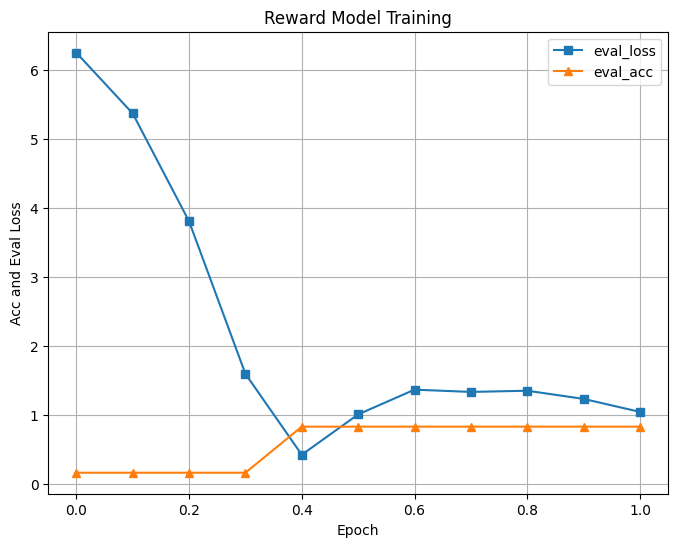

In [5]:
exp_dir = "/workspace/exp14"
param_save_path = "model1"
last_check_point = "checkpoint-100"
train_data_path = f"{exp_dir}/{param_save_path}/{last_check_point}/trainer_state.json"

import json
with open(train_data_path) as f:
    train_data = json.load(f)
    log_hist = train_data["log_history"]

train_epoch = []
eval_epoch = []
train_loss = []
eval_loss = []
eval_acc = []
for i, log_hist_data in enumerate(log_hist):
    if "eval_loss" in log_hist_data:
        eval_epoch.append(log_hist_data["epoch"])
        eval_loss.append(log_hist_data["eval_loss"])
        eval_acc.append(log_hist_data["eval_accuracy"])
    else:
        train_epoch.append(log_hist_data["epoch"])
        train_loss.append(log_hist_data["loss"])

import matplotlib.pyplot as plt
# Create a new figure with a specific size
plt.figure(figsize=(8, 6))

# Plot each set of values with markers and labels
#plt.plot(train_epoch, train_loss, marker='o', label='train_loss')
plt.plot(eval_epoch, eval_loss, marker='s', label='eval_loss')
plt.plot(eval_epoch, eval_acc, marker='^', label='eval_acc')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Acc and Eval Loss')
plt.title('Reward Model Training')

# Enable the legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()



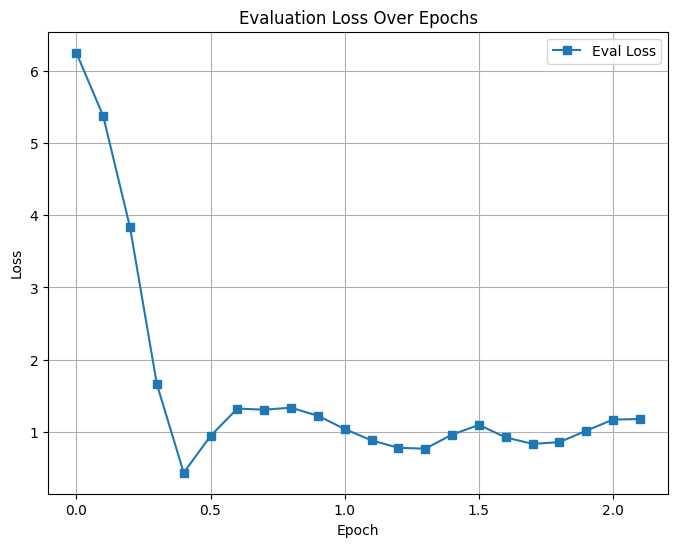

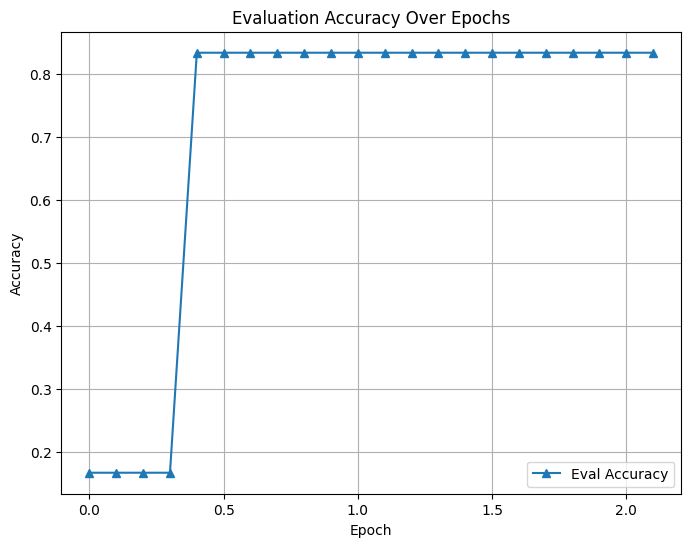

In [4]:
import json
import matplotlib.pyplot as plt

# Paths
exp_dir = "/workspace/exp14"
param_save_path = "model2"
last_check_point = "checkpoint-210"
train_data_path = f"{exp_dir}/{param_save_path}/{last_check_point}/trainer_state.json"

# Load log history
with open(train_data_path) as f:
    train_data = json.load(f)
log_hist = train_data["log_history"]

# Extract epochs & metrics
eval_epoch, eval_loss, eval_acc = [], [], []
for entry in log_hist:
    if "eval_loss" in entry:
        eval_epoch.append(entry["epoch"])
        eval_loss.append(entry["eval_loss"])
        eval_acc.append(entry["eval_accuracy"])

# Figure 1: Evaluation Loss over Epochs
plt.figure(figsize=(8, 6))
plt.plot(eval_epoch, eval_loss, marker='s', linestyle='-', label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evaluation Loss Over Epochs')
plt.grid(True)
plt.legend()

# Figure 2: Evaluation Accuracy over Epochs
plt.figure(figsize=(8, 6))
plt.plot(eval_epoch, eval_acc, marker='^', linestyle='-', label='Eval Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.show()
